# Multiple correction

If we wanted to know which taxa were associated with a certain variable in our dataset, we could conduct a test for each taxa, one by one, and check the p-value. All the ones with low p-values (<0.05) we would call significantly associated with our variable. The problem is that the p-value is misleading when conducting multiple statistical tests. If the Null Hypothesis (H0) is true the p-value is expected to be anywhere between 0 and 1 (uniform distribution). As such, if enough statistical tests are conducted, some (~5%) of the p-values will, by chance, be lower than 0.05, even if there are no true associations in the data.

Therefore, when conducting multiple tests it is best practice to adjust the p-values.

### Getting in-depth:
* [This paper](https://www.nature.com/articles/nmeth.2900) explains the concept of multiple correction in-depth for a non-statistical reader.
* [This paper](https://www.nature.com/articles/nmeth.4120) goes further into interpretation of p-values when many tests are conducted.

### Simulation
Let's try to simulate some random data, and see how the p-value look like.

In [1]:
# We use the rnorm() function to generate random normally distributed data with a mean of 0 and standard deviation of 1
# Here is an example with 20 random (normallly distributed) numbers:
rnorm(20)

[1]  0.18962312  0.34319262 -0.63951482 -0.17784425  0.41262153 -0.40763002
 [7] -1.37194815 -0.74699147 -0.10218278 -0.34138075  0.28610312 -0.74566922
[13] -0.01753478  1.04465208 -0.29696414  0.24470453 -0.37223301  0.15926402
[19] -0.45830829 -1.30092569

If we do a t-test comparing two randomlly created sets of numbers, they should not be significantly different (at least 95% of the time).

In [2]:
# Set seed (for reproducibility)
set.seed(42)

t.test(rnorm(20), rnorm(20))


	Welch Two Sample t-test

data:  rnorm(20) and rnorm(20)
t = 1.2044, df = 36.976, p-value = 0.2361
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3158495  1.2416732
sample estimates:
 mean of x  mean of y 
 0.1919200 -0.2709918 


As expected, not significant. However, let's try to do this 10000 times, and plot a histogram of the p-values:

In [3]:
# Set seed (for reproducibility)
set.seed(42)

# 10000 t-tests with random data
random_ttests <- sapply(1:10000, function(x) t.test(rnorm(20), rnorm(20))$p.value)

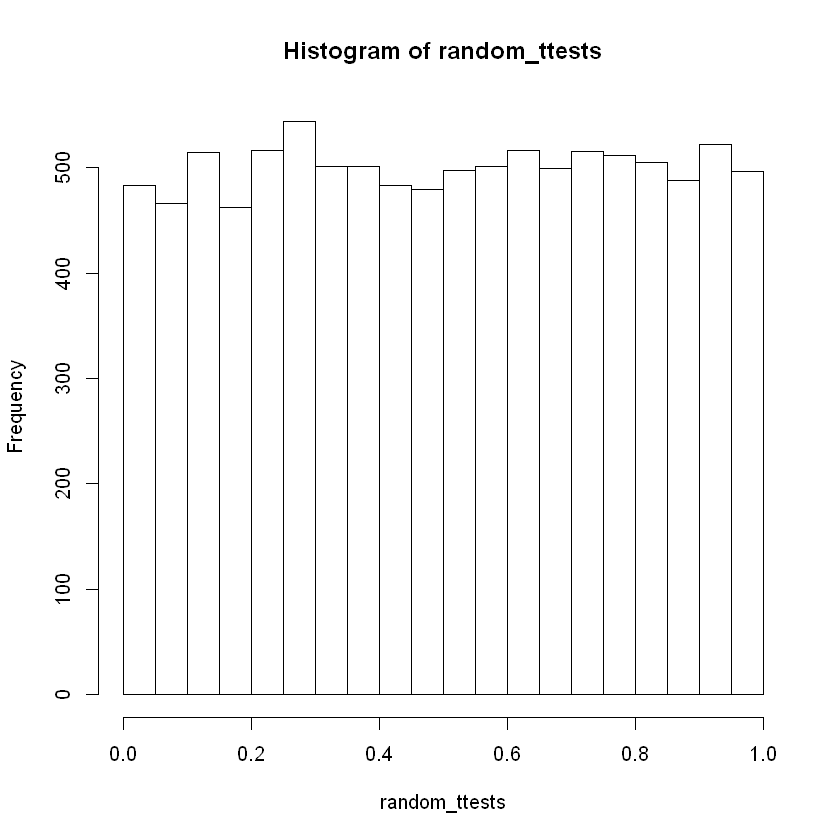

In [4]:
# Histogram
hist(random_ttests, breaks = 20)

Let's count how many of the p-values are below 0.05:

In [5]:
sum(random_ttests <= 0.05)/length(random_ttests)

[1] 0.0483

Around 5% of the p-values are lower than 0.05

### FDR correction
The most common way to adjust the p-values for this problem in the microbiome field is to control the False Discovery Rate (FDR) with method developed by Benjamini and Hochberg (BH), see details on this method in the paper linked above. Assuming a cutoff of 0.05 for assigning statistical significance, then for the orginal p-values we accept a 5% chance of falsely denoting **a single test** significant even though it is not. With the FDR correction we accept that 5% of **all the tests we call significant** are not truely significant.

#### In R:

In [6]:
adjusted_pvals <- p.adjust(random_ttests, method = "BH")

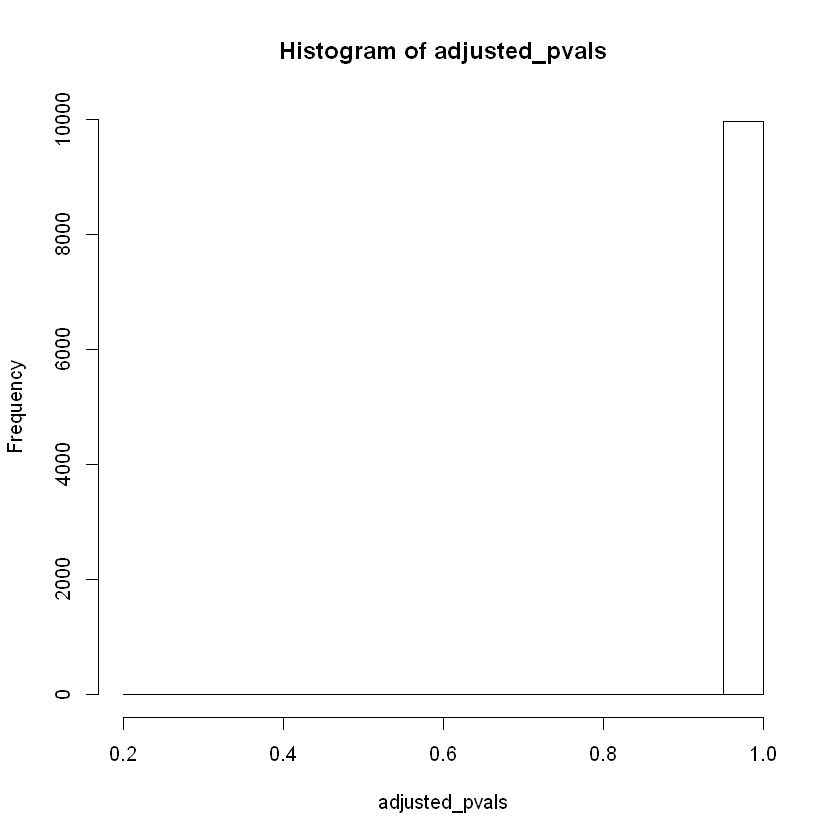

In [7]:
# Histogram
hist(adjusted_pvals)

All adjusted p-values are close to 1 (not significant)

##### Let's try to add a single t-test which should be significant and check if it is still significant after adjustment

In [8]:
# Set seed (for reproducibility)
set.seed(4)

# Low p-value
ttest_sig <- t.test(rnorm(20, mean = 0), rnorm(20, mean = 2))$p.value

# Append to the 10000 p-values
random_ttests_plus1 <- c(random_ttests, ttest_sig)

# Adjust p-values
adjusted_pvals_plus1 <- p.adjust(random_ttests_plus1, method = "BH")

# Print
print("Original p-value:")
ttest_sig
print("FDR-adjusted p-value:")
adjusted_pvals_plus1[length(adjusted_pvals_plus1)]

[1] "Original p-value:"


[1] 1.672039e-08

[1] "FDR-adjusted p-value:"


[1] 0.0001672207

The p-value is higher, but still significant.

### FWER correction
A simpler correction than BH is the Bonferroni correction. It is rarely used in the microbiome field, as it is much more strict and less powerful, but it is common in the field of **G**enome-**w**ide **a**ssociation **s**tudies (GWAS).

FWER is the abbreviation for **F**amily**w**ise **e**rror **r**ate, and it is the rate at which we find **at least 1** false positive among a series of hypothesis tests. With Bonferroni we simply multiply all p-values with the number of tests that were conducted

#### In R:

In [10]:
# Adjust p-values
adjusted_pvals_plus1_FWER <- p.adjust(random_ttests_plus1, method = "bonferroni")

print("FWER-adjusted p-value:")
adjusted_pvals_plus1_FWER[length(adjusted_pvals_plus1_FWER)]

[1] "FWER-adjusted p-value:"


[1] 0.0001672207

In this rare case with only 1 highly significant test among of series of random tests, the FDR and FWER correction results in the same adjusted p-value, but in most real-world cases the FWER correction will result in higher adjusted p-values.